# BaZrO3:Ti study

This section present a short overview of the use of the main features of Hylight, applied a the system $BaZrO_3:Ti$.
The synthesis and luminescence characterization of the doped material showed a blue luminescence that we tried to simulate.
The cell used was a 3x3x3 supercell of the conventional cell of $BaZrO_3$ in which one $Zr$ atom was substituted with a $Ti$ atom.
All computations were performed with VASP.

## Preliminaries
Here are some utility functions and import that will be used throughout the study.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from hylight.constants import *
import logging

logging.getLogger().setLevel(logging.INFO)  # setting the logging level to INFO

In [3]:
# Helper functions to deal with experimental spectrum

def best_max(raw_x, raw_y, f=0.95):
    "Fit a 2nd order polynom to get a position of the maximum without the noise."
    guess = np.max(raw_y)

    y = raw_y[raw_y > f * guess]
    x = raw_x[raw_y > f * guess]
    
    x1, x2, x3, x4 = np.mean(x**1), np.mean(x**2), np.mean(x**3), np.mean(x**4)
    
    x2y = np.mean(x**2 * y)
    xy = np.mean(x * y)
    my = np.mean(y)

    A = np.array([[x4, x3, x2],
                  [x3, x2, x1],
                  [x2, x1, 1.]])

    B = np.array([[x2y, xy, my]]).transpose()

    alpha, beta, gamma = np.linalg.solve(A, B)[:, 0]
    
    return -0.5 * beta / alpha, gamma - 0.25 * beta**2 / alpha
    
def load_exp(path, sep=";", skip=0):
    exp = np.loadtxt(path,
                     delimiter=sep,
                    skiprows=skip)
    x, y = eV1_in_nm / exp[:, 0], exp[:, 1]
    xmax, ymax = best_max(x, y)
    y /= ymax
    return x, y, xmax

def select_interval(x, y, emin, emax, norm=True, npoints=None):
    slice_ = (x > emin) * (x < emax)
    xs, ys = x[slice_], y[slice_] / (np.max(y[slice_]) if norm else 1.)
    
    if npoints is not None:
        emin = max(np.min(xs), emin)
        emax = min(np.max(xs), emax)
        xint = np.linspace(emin, emax, npoints)
        return xint, interp1d(xs, ys)(xint)
    
    return xs, ys

To perform the simulation of the spectrum of BaZrO3:Ti we need a few pieces of information.
The following diagram shows the four points A, B, C and D that need to be computed in DFT.
We used constrained DFT to compute B and C with an explicit hole in the VBM and an electron in the CBM.
The cDFT and the regular DFT computations provides us with total energies and the positions $R_G$ and $R_E$ that we will use as inputs in the next section.

![figure_1](./energy_diagram.png "Figure 1: Investigated electronic states")

Given the geometry $R_G$ we also perform a DFPT computation to get the eigen values and eigenvectors of the dynamical matrix, that is we get the $\Gamma$ vibrational modes of the crystal.

The modes are extracted from the VASP output file and stored in the `OUTCAR.npz` with the command line tool `hylight-modes`:
```sh
$ hylight-modes vasp OUTCAR OUTCAR.npz
Loaded 405 modes from OUTCAR.
Wrote OUTCAR.npz.
```

## Electronic and vibrational parameters

Here we declare the inputs that will be used later.

In [4]:
fc_shift_es = 0.1091  # B-C
fc_shift_gs = 0.2871  # D-A
e_adia = 2.970886  # C-A

e_vert = e_adia - fc_shift_gs  # C-D

outcar = "OUTCAR.npz"  # vibrations
poscar_gs = "POSCAR_GS"  # R_G
poscar_es = "POSCAR_S1"  # R_E
T = 300  # measure temperature (K)

print(f"Adiabatic energy difference: {e_adia:0.3f} eV")
print(f"Vertical energy difference: {e_vert:0.3f} eV")

Adiabatic energy difference: 2.971 eV
Vertical energy difference: 2.684 eV


## Vibrational properties investigation

We now plot the spectral function to identify important modes.

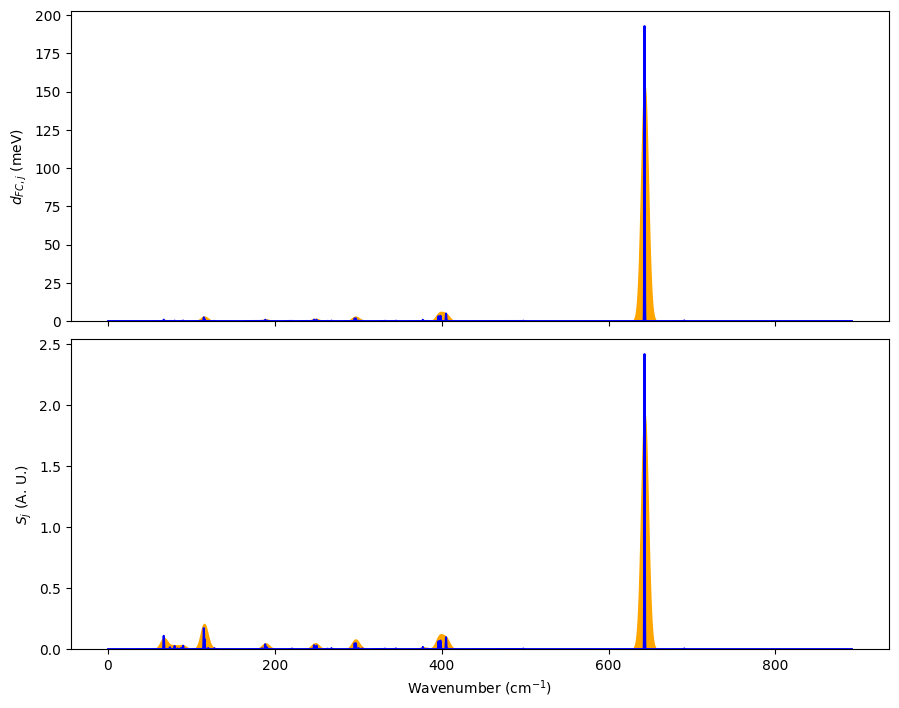

In [5]:
from hylight.multi_phonons import plot_spectral_function

fig, (ax_fc, ax_s) = plot_spectral_function(outcar, poscar_gs, poscar_es, use_cm1=True, disp=5e-1, mpl_params={
    "S_stack": {"color": "orange"},
    "FC_stack": {"color": "orange"},
    "S_peaks": {"color": "blue", "lw": 1.5},
    "FC_peaks": {"color": "blue", "lw": 1.5},
})

ax_fc.set_ylabel("$d_{FC,j}$ (meV)")
ax_s.set_ylabel("$S_j$ (A. U.)")
plt.tight_layout()
fig.set_size_inches((9, 7))

There is obsivously one very dominant mode. We can export it to a Jmol file to visualize it.

In [6]:
from hylight.loader import load_phonons
from hylight.multi_phonons import compute_delta_R

delta_R = compute_delta_R(poscar_gs, poscar_es) * 1e-10  # careful, Mode.huang_rhys expects SI units
modes, _, _ = load_phonons(outcar)

big_modes = [m for m in modes if m.huang_rhys(delta_R) > 2]
print("Degenerated modes:", len(big_modes))

from hylight.jmol import export

mode = big_modes[0]
export(
    "big_mode.jmol",
    mode,
    scale=5.0,
    unitcell=mode.lattice,  # show the unitcell as a box
    bonds = [  # bonds to show, with length between 0 and 2.2 A
        ("Zr", "O", 0, 2.2),
        ("Ti", "O", 0, 2.2),
    ],
    atom_colors = [  # colors to show atoms
        ("Ba", "green"),
        ("Zr", "blue"),
        ("Ti", "grey"),
        ("O", "red"),
    ],
)

Degenerated modes: 1


Here is the result in Jmol:

![big_mode_jmol.png](./big_mode_jmol.png)

We can clearly see that the mode is a pure respiration mode of the $TiO_6$ with the $O_h$ symmetry.

## Line width approximation

We now will use a semi-classical model to approximate the width of the band.
The specific model for the width is a 1D reduction of the system, and the effective vibration frequency is computed as a mean over FC shifts.

In [7]:
from hylight.guess_width import guess_width, OmegaEff, WidthModel

width = guess_width(outcar, (poscar_gs, poscar_es), fc_shift_gs, fc_shift_es, T, omega_eff_type=OmegaEff.FC_MEAN, width_model=WidthModel.ONED)
print(f"Guessed line FWHM = {width*1e3:0.1f} meV")

S = 3.4298721572871944
d_fc^e,v = 0.08390772346494868
ex_fwhm = 0.4905400232911907 eV
Using a Gaussian line shape.
Guessed line FWHM = 468.5 meV


## Spectrum simulation

Finally, taking vibrational and electronic parameters into account we simulate the spectrum.

In [8]:
from hylight.multi_phonons import compute_spectrum

e, sp = compute_spectrum(  # simulate the spectrum
    outcar,
    (poscar_gs, poscar_es),
    e_adia,
    width,
)

_, max_th = max(zip(sp, e))  # extract the maximum of emission energy
print(f"Computed maximum of emission: {max_th:.3} eV")

Total Huang-Rhys factor 3.4298721572871944.


Using a Gaussian line shape.
Computed maximum of emission: 2.82 eV


## Plotting

Here we load the experimental data that will be used for comparision with the simulation.

In [9]:
exp_e, exp_i, max_emission = load_exp("lum_BaZrO3_277nm_220518_corr.csv")

print(f"Measured maximum of emission: {max_emission:.3} eV")

Measured maximum of emission: 2.62 eV


Finally we setup a plot to show the result of the simulation against the measurement.

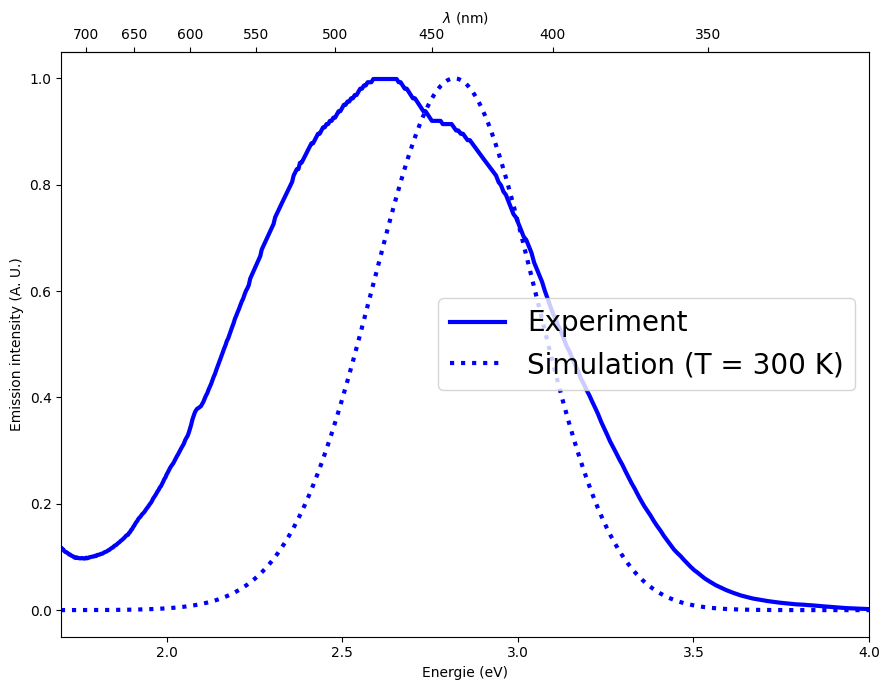

In [10]:
plt.figure(figsize=(9, 7))

e, sp = e[1:], sp[1:]
exp_e, exp_i = exp_e[1:], exp_i[1:]
plt.plot(exp_e, exp_i, "b", lw=3, label="Experiment")
plt.plot(e, sp, ":", color="b", lw=3, label=f"Simulation (T = {T} K)")

plt.xlim(1.7, 4)
plt.xlabel("Energie (eV)")
plt.ylabel("Emission intensity (A. U.)")

ax = plt.gca()
np.seterr(divide='ignore')  # there is a division by zero occuring in the next line but it is irrelevant for our xlim
secax = ax.secondary_xaxis('top', functions=(lambda x: eV1_in_nm / x, lambda x: eV1_in_nm / x))
secax.set_xlabel("$\lambda$ (nm)")

plt.tight_layout()
leg = plt.legend(prop={"size": 20})
plt.savefig("bzo_spectra.png")

It appears that the simulated transition matches the shoulder on the right of the measured band.
We believe that the left part of the band is the result of the luminescence of a different defect that we have not investigated.